In [1]:
from ML_utils import ML_utils
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
dir_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\Dataset'
x = np.load(os.path.join(dir_path,'vec_x_neg3000_pos3000.npy'))
y = np.load(os.path.join(dir_path,'vec_y_neg3000_pos3000.npy'))

In [3]:
x_train = np.concatenate((x[:2400],x[3000:5400]))
y_train = np.concatenate((y[:2400],y[3000:5400]))
x_test = np.concatenate((x[2400:3000],x[5400:6000]))
y_test = np.concatenate((y[2400:3000],y[5400:6000]))
del x,y

In [4]:
class Dataset(data.Dataset):
    def __init__(self,x,y,transform=None,target_transform=None):
#         self.transform = transform
#         self.target_transform = target_transform
        self.data_X = x
        self.data_Y = y
        
    def __getitem__(self, index):
        X = self.data_X[index]
        Y = self.data_Y[index]
#         if self.transform != None:
#             X = self.transform(X)
#         if self.target_transform != None:
#             Y = self.transform(Y)
        return X, Y
                
    def __len__(self):
        return len(self.data_X)

In [5]:
batch_size = 400
train_data = Dataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,shuffle=False, num_workers=0)
test_data = Dataset(x_train,y_train)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size ,shuffle=False, num_workers=0)
del train_data,test_data,x_train,y_train,x_test,y_test

In [6]:
seq_len = 30
input_size = 300
rnn_hidden_size = 100
rnn_num_layers = 4
output_size = 2
hidden_size = seq_len*rnn_hidden_size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

class LSTM_model(nn.Module):
    def __init__(self, ):
        super(LSTM_model, self).__init__()
        self.lstm0 = nn.LSTM(
            input_size=input_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.linear0 = nn.Linear(hidden_size, output_size)
        for name,p in self.named_parameters():
            if (name.find('rnn') == 0):
                nn.init.normal_(p, mean=0.0, std=0.001)
            elif (name.find('linear') == 0) and (name.find('weight') == 0):        
                nn.init.xavier_normal_(p)
    def forward(self, x, h0,c0):
        # [b, seq, h]
        out, (h0_,c0_) = self.lstm0(x, (h0,c0))
        out = out.reshape(-1,hidden_size)
        out = self.linear(out)
        out = nn.functional.relu(out)
        out = self.linear0(out)
        out = nn.functional.softmax(out,dim=1)
        return out, (h0_,c0_)

In [7]:
#[rnn_layer,b,hidden_size]
h0 = torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
c0 =  torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
model = LSTM_model()
model.cuda('cuda:0')

LSTM_model(
  (lstm0): LSTM(300, 100, num_layers=4, batch_first=True)
  (linear): Linear(in_features=3000, out_features=3000, bias=True)
  (linear0): Linear(in_features=3000, out_features=2, bias=True)
)

In [8]:
def train(lr,epoch):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    global h0
    global c0
    trainloss_list = []
    testloss_list = []
    for epoch in range(epoch):
        data_iter = iter(trainloader)
        for batch in data_iter:
            x = batch[0].to(device=device,dtype=dtype)
            y = batch[1].to(device=device,dtype=dtype)
            output,(h0_,c0_) = model(x, h0, c0)
            h0 = h0_.detach()
            c0 = c0_.detach()
            loss = criterion(output, y)
            model.zero_grad()
            loss.backward()
    #         for p in model.parameters():
    #             torch.nn.utils.clip_grad_norm_(p, 10)
            optimizer.step()
    #     print("Iteration: {} loss {}".format(epoch+1, loss.item()))
    #     loss_list.append(loss.item())
        if (epoch+1) % 10 == 0:
            print("Iteration: {} Train.loss {}".format(epoch+1, loss.detach()))
            trainloss_list.append(loss.item())
        data_iter = iter(testloader)
        for batch in data_iter:
            x = batch[0].to(device=device,dtype=dtype)
            y = batch[1].to(device=device,dtype=dtype)
            output,(h0_,c0_) = model(x, h0, c0)
            h0 = h0_.detach()
            c0 = c0_.detach()
            loss = criterion(output, y)
        if (epoch+1) % 10 == 0:
            print("Iteration: {} Test.loss {}".format(epoch+1, loss.detach()))
            testloss_list.append(loss.item())
    return trainloss_list,testloss_list

Iteration: 10 Train.loss 0.24976544082164764
Iteration: 10 Test.loss 0.24756138026714325
Iteration: 20 Train.loss 0.06430943310260773
Iteration: 20 Test.loss 0.055881958454847336
Iteration: 30 Train.loss 0.05166279897093773
Iteration: 30 Test.loss 0.04590557888150215
Iteration: 40 Train.loss 0.041430093348026276
Iteration: 40 Test.loss 0.03774380683898926
Iteration: 50 Train.loss 0.03162067010998726
Iteration: 50 Test.loss 0.02966400794684887
Iteration: 60 Train.loss 0.027990169823169708
Iteration: 60 Test.loss 0.027434952557086945
Iteration: 70 Train.loss 0.024049222469329834
Iteration: 70 Test.loss 0.023939939215779305
Iteration: 80 Train.loss 0.021655485033988953
Iteration: 80 Test.loss 0.021562933921813965
Iteration: 90 Train.loss 0.018364161252975464
Iteration: 90 Test.loss 0.018147660419344902
Iteration: 100 Train.loss 0.013968524523079395
Iteration: 100 Test.loss 0.013854865916073322
Iteration: 110 Train.loss 0.013622084632515907
Iteration: 110 Test.loss 0.013537745922803879
Ite

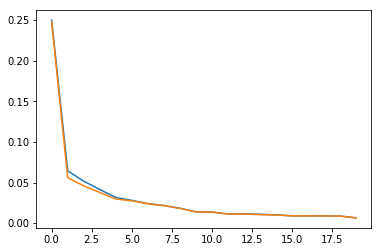

In [9]:
trainloss_list,testloss_list = train(lr=0.0001,epoch=200)
plt.plot(trainloss_list)
plt.plot(testloss_list)
plt.show()

In [47]:
#儲存
save_model_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\word2vec_model\sentiment_analysis_model'
torch.save(model.state_dict(), save_model_path)
torch.save({'sentiment_analysis_model_h0':h0,'sentiment_analysis_model_c0':c0},save_model_path+'lstm')

In [7]:
# 讀取
# save_model_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\word2vec_model\sentiment_analysis_model'
# model = LSTM_model()
# model.cuda()
# check_point1 = torch.load(save_model_path+'lstm')
# model.load_state_dict(torch.load(save_model_path))
# h0 = check_point1['sentiment_analysis_model_h0']
# c0 = check_point1['sentiment_analysis_model_c0']

In [8]:
import re
from gensim.models import word2vec
import logging
import jieba
model.eval()
class predict_config():
    def __init__(self,h0,c0,word_vec_path):
        self.word_vec_model = word2vec.Word2Vec.load(word_vec_path)
        self.pre_h0 = h0.clone().detach()
        self.pre_c0 = c0.clone().detach()
        self.padding = np.zeros((1,300),dtype=np.float32)

def jieba_string(chat):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    logging.disable(50)
    output = []
    # jieba custom setting.
    jieba.set_dictionary('jieba_dict/dict.txt.big')
    # load stopwords set
    #將停用詞每row分別加進集合
    stopword_set = set()
    #設置停用詞讀取路徑
    with open('jieba_dict/robot_stop_1.txt','r', encoding='utf-8') as stopwords:
        for stopword in stopwords:
            stopword_set.add(stopword.strip('\n'))   #移除頭尾換行 strip('\n')
    chat = chat.strip('\n')
    words = jieba.cut(chat, cut_all=False,HMM=True)    #進行斷詞
    for word in words:
        #依每個詞判斷是否為停用詞(不是就寫入)
        if word not in stopword_set:
            output.append(word)
    return output

def chat(chat,config):
    jieba_list = jieba_string(chat)
    if len(jieba_list) > seq_len:
        jieba_list = jieba_list[:seq_len]
    if len(jieba_list) < seq_len:
        for num in range(seq_len-len(jieba_list)):
            jieba_list.append(0)
    vec_array = np.zeros((1,300),dtype=np.float32)
    for word in jieba_list:
        if word == 0:
            vec = config.padding
            vec_array = np.concatenate((vec_array,vec),axis=0)
        else:
            try:
                vec = np.array(config.word_vec_model.wv.get_vector(word),np.float32).reshape(1,300)
                vec_array = np.concatenate((vec_array,vec),axis=0)
            except KeyError:
                vec = config.padding
                vec_array = np.concatenate((vec_array,vec),axis=0)
    X = vec_array[1:].reshape(1,-1,300)
    X = torch.tensor(X)
    return X

def input_to_predict(chat_input,config):
    x = chat(chat_input,config)
    x = x.to(device=device,dtype=dtype)
    output,(h0_,c0_)= model(x, config.pre_h0[:,:len(x),:].clone(), config.pre_c0[:,:len(x),:].clone())
#     config.pre_h0 = h0_.detach()
#     config.pre_c0 = c0_.detach()
    predict = torch.argmax(output.detach())
    print(chat_input)
    if predict == 0:
        print('Bad!!')
    if predict == 1:
        print('Good!!')
    return output

In [9]:
word_vec_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\word2vec_model\word2vec_model'
config = predict_config(h0,c0,word_vec_path)

In [10]:
print('test:')
input_to_predict('很親切',config)
input_to_predict('棒棒達',config)
input_to_predict('非常不錯',config)
input_to_predict('爛爆!!!!!!!!!!!!!!!!!!!!',config)
input_to_predict('服務超差，真的4傻眼貓咪',config)
input_to_predict('東西不錯就是包裝那麼簡陋，連個盒子都沒有',config)
input_to_predict('不太好，晚上被卡拉OK的聲音干擾到很晚。樓下的飯店也搞出很多污染。',config)
input_to_predict('火龍果很小，而且還有一個爛了，發霉了！',config)
input_to_predict('啥蘋果？又不甜又不脆，太粉了，沒味道，最失望的購物。',config)
input_to_predict('啥完全是假貨，跟原來買的用的感覺一點都不一樣，假的不行了，洗髮沒有泡還粘在頭皮上',config)
input_to_predict('服務很糟糕...，但整體來說還不錯。',config)
input_to_predict('房間還不錯，但服務很差。',config)
input_to_predict('無言薯條',config)
input_to_predict('好棒',config)
input_to_predict('阿不就好棒棒',config)
input_to_predict('氣死我了',config)
input_to_predict('484淘寶的服務都很差，無言薯條',config)
input_to_predict('好棒棒',config)
input_to_predict('生77',config)
input_to_predict('良心事業',config)
input_to_predict('房間還一般，但服務很差。',config)
input_to_predict('東西很便宜，店員很親切。',config)
input_to_predict('爽爽爽爽爽爽',config)
input_to_predict('出貨慢，態度差。',config)
input_to_predict('店長人很好 鳩咪',config)
input_to_predict('東西好ㄘㄘㄘㄘ',config)
input_to_predict('以後一定不來了',config)
input_to_predict('除了東西好吃之外，整體來說不佳。',config)
input_to_predict('真的是好棒棒',config)
input_to_predict('大推',config)
input_to_predict('不會再來買',config)
input_to_predict('除了景觀不錯，整體來說不佳。',config)
input_to_predict('餐點很差，整體來說不錯。',config)
input_to_predict('服務用心的好賣家~',config)
input_to_predict('店家很母湯',config)
input_to_predict('很瞎',config)
input_to_predict('一定再來買',config)
input_to_predict('正品',config)
input_to_predict('決不會再買',config)

test:
很親切
Good!!
棒棒達
Good!!
非常不錯
Good!!
爛爆!!!!!!!!!!!!!!!!!!!!
Bad!!
服務超差，真的4傻眼貓咪
Bad!!
東西不錯就是包裝那麼簡陋，連個盒子都沒有
Bad!!
不太好，晚上被卡拉OK的聲音干擾到很晚。樓下的飯店也搞出很多污染。
Bad!!
火龍果很小，而且還有一個爛了，發霉了！
Bad!!
啥蘋果？又不甜又不脆，太粉了，沒味道，最失望的購物。
Bad!!
啥完全是假貨，跟原來買的用的感覺一點都不一樣，假的不行了，洗髮沒有泡還粘在頭皮上
Bad!!
服務很糟糕...，但整體來說還不錯。
Good!!
房間還不錯，但服務很差。
Bad!!
無言薯條
Good!!
好棒
Good!!
阿不就好棒棒
Bad!!
氣死我了
Bad!!
484淘寶的服務都很差，無言薯條
Bad!!
好棒棒
Good!!
生77
Bad!!
良心事業
Good!!
房間還一般，但服務很差。
Bad!!
東西很便宜，店員很親切。
Good!!
爽爽爽爽爽爽
Good!!
出貨慢，態度差。
Bad!!
店長人很好 鳩咪
Good!!
東西好ㄘㄘㄘㄘ
Good!!
以後一定不來了
Bad!!
除了東西好吃之外，整體來說不佳。
Bad!!
真的是好棒棒
Good!!
大推
Good!!
不會再來買
Good!!
除了景觀不錯，整體來說不佳。
Bad!!
餐點很差，整體來說不錯。
Good!!
服務用心的好賣家~
Good!!
店家很母湯
Bad!!
很瞎
Bad!!
一定再來買
Good!!
正品
Good!!
決不會再買
Good!!


tensor([[0.0130, 0.9870]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
while True:
    print('停止請輸入: '+'exit predict')
    input_chat = input('輸入評論：')
    input_to_predict(input_chat,config)
    if input_chat == 'exit predict':
        break

停止請輸入: exit predict
